In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

import warnings 
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv("AirPassengers.csv")
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format = True)
indexedDataset = dataset.set_index(['Month']) #index variable is month

In [3]:
from datetime import datetime
indexedDataset.head(5)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
indexedDataset.tail(5)

,Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


1960 is the last year.

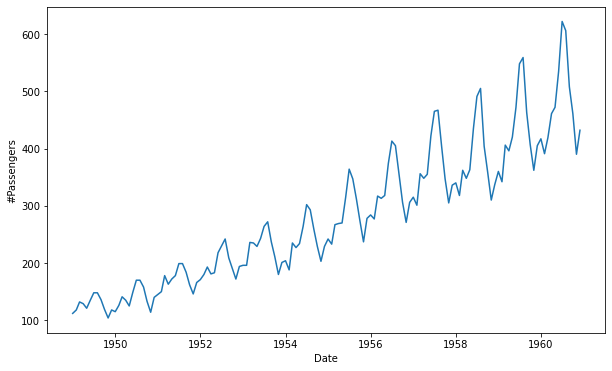

In [5]:
#PLOT 
plt.xlabel("Date")
plt.ylabel("#Passengers")
plt.plot(indexedDataset)

Data is non-stationary. We can see the trend going up and mean is not stationary.

### TESTING STATIONARITY

In [6]:
#Determing rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window of 12 represents 12 months
#gives rolling mean at an yearly level. Same with standard deviation

rolstd = indexedDataset.rolling(window=12).std()

print(rolmean, rolstd)

            Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]             Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


In [7]:
rolmean.isnull().sum()


Passengers    11
dtype: int64

 11 values are NaN

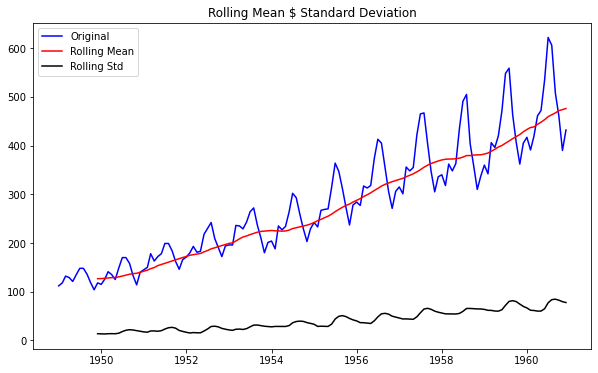

In [8]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color = 'blue', label= 'Original')
mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean $ Standard Deviation')
plt.show(block = False)

shows that it is not stationary

In [9]:
#Perform Dickey-Fuller test
from  statsmodels.tsa.stattools import adfuller #function for the test

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['Passengers'], autolag = 'AIC') #Aiterion gives the actual & exact values in TS and analyses the differences btwn them 

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observatios Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  0.815369
p-value                         0.991880
#Lags Used                     13.000000
Number of Observatios Used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


Given a p-value of 0.9, we cannot reject the null hypothesis. Null hypothesis is that there is a unit root in an AR model, which implies that the data series is not stationary.

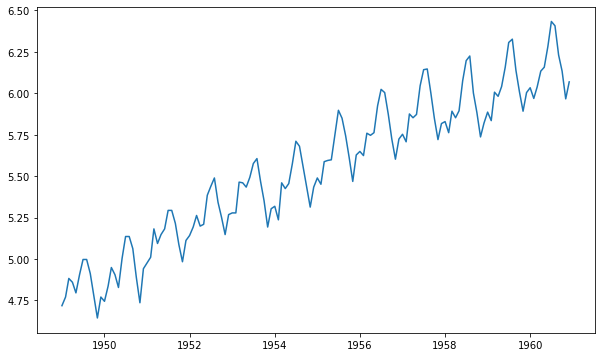

In [10]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

Trend remains the same even while working with log values

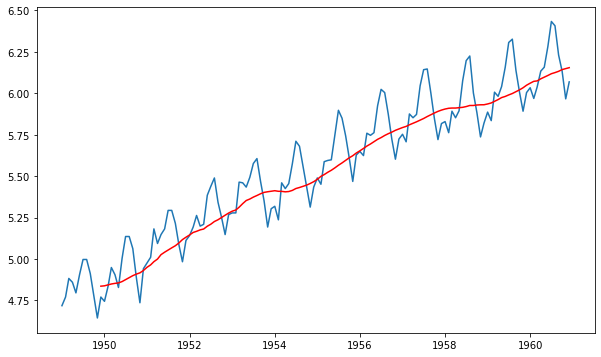

In [11]:
movingAverage = indexedDataset_logScale.rolling(window =12).mean()
movingSTD = indexedDataset_logScale.rolling(window = 12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color ='red')

Data is not stationary again. Has an upward trend

In [12]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)
#We do this in order to get the TS as stationary.
#it is not standard.. sometimes you need to square, roots etc instead of using logs

#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace = True)
datasetLogScaleMinusMovingAverage.head(10)

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window =12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label = 'Original')
    mean = plt.plot(movingAverage, color='red', label = 'Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    #Perform Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

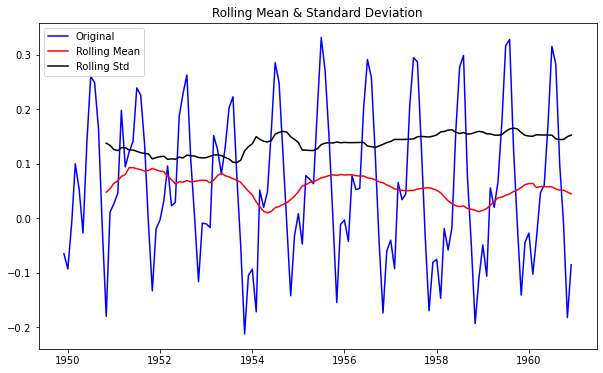

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [14]:
test_stationarity(datasetLogScaleMinusMovingAverage)

1. Has no trend. 
2. p-value is less than 0.05 (0.022235)
3. Test statistic and Critical value are almost equal. Helps to determine whether your data is stationary or not

Need to calculate the weighted average of TS. This is to determine the trend inside a TS

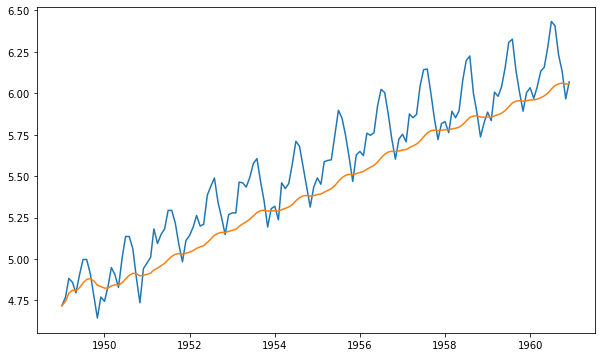

In [15]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage)

Average increases. The trend is upward wrt time

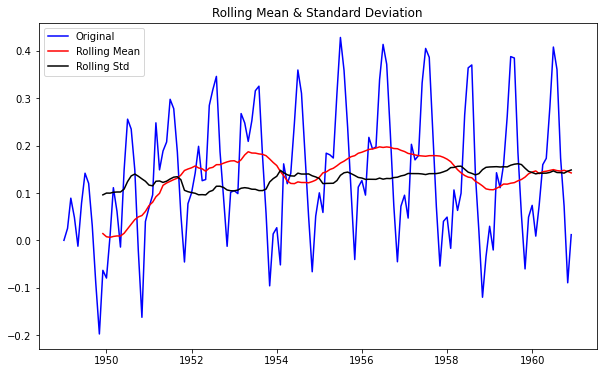

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

 P-value less than 0.05 (0.005737) thus stationary
 We need now to shift the values into TS so that we can use it in forecasting.

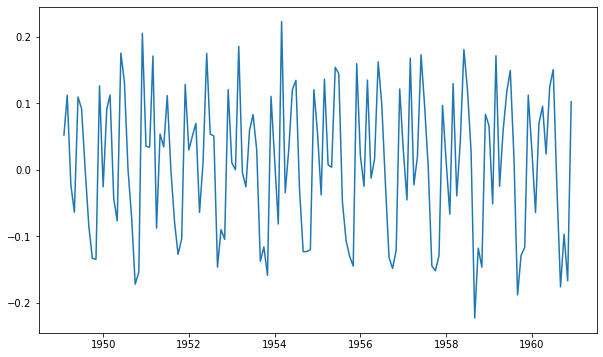

In [17]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

Here, the lag is 1 or the differential TS of one. D=1. 

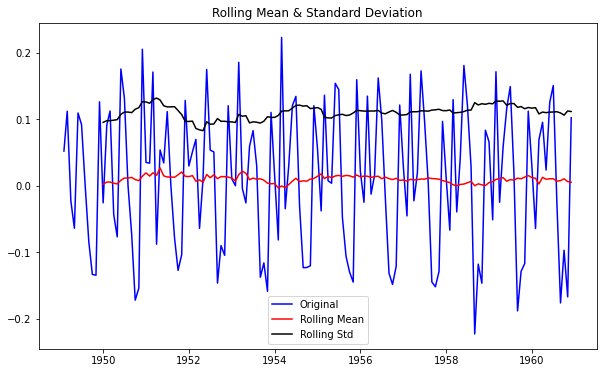

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [18]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

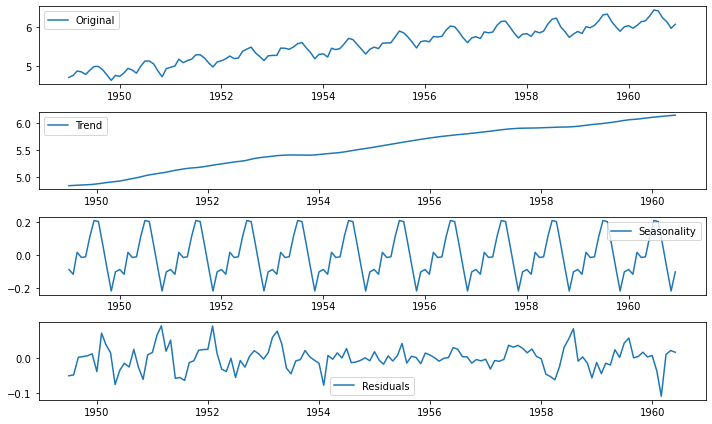

In [19]:
#Components of TS
from statsmodels.tsa.seasonal import seasonal_decompose
#decompose separate 3 components i.e. trend, seasonal and residual
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid #residuals are the irregularities. They don't have shape, size and pattern.

plt.subplot(411)
plt.plot(indexedDataset_logScale, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()



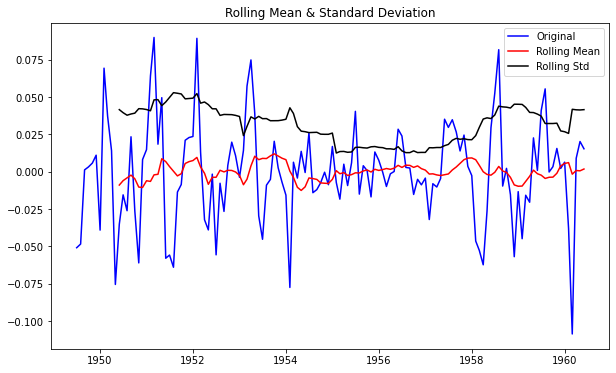

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [20]:
#We'll check if the noise is stationary or not
#residual is stored in the decomposedLogData variable
decomposedLogData = residual
decomposedLogData.dropna(inplace = True)
decomposedLogData = pd.DataFrame(decomposedLogData)
decomposedLogData.columns = ["Passengers"]
test_stationarity(decomposedLogData)

Text(0.5, 1.0, 'Autocorrelation Function')

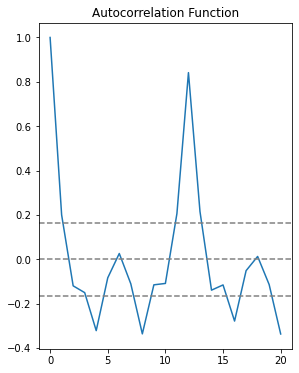

In [21]:
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols') #there are other methods apart from Ordinary Least Square (OLS)

#plot ACF for Q
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color = 'gray')
plt.title('Autocorrelation Function')
            

            

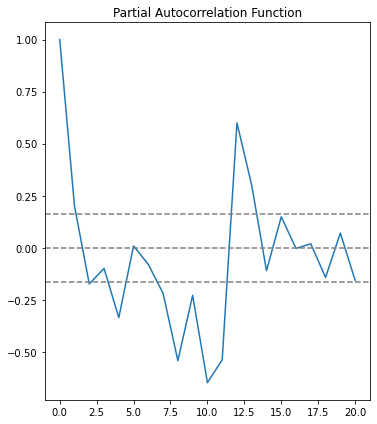

In [22]:
#plot PACF for P
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

You need to check where the line first cuts the 0 mark. Around the 2 mark for both ACF and PACF.

C:\Users\Anarchy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anarchy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting AR model


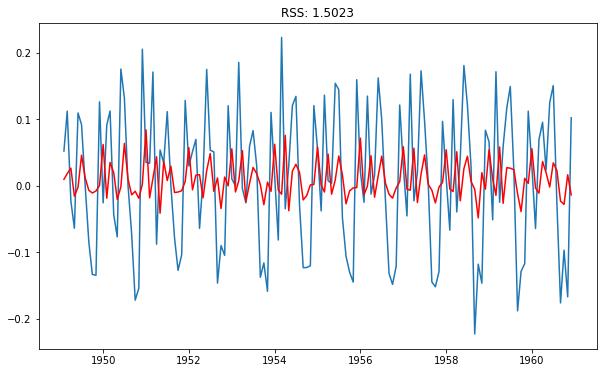

In [23]:
from statsmodels.tsa.arima_model import ARIMA

#AR model
model = ARIMA(indexedDataset_logScale, order = (2, 1, 0)) #P=2, D=1 & Q=2
results_AR = model.fit(disp = -1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - datasetLogDiffShifting["Passengers"])**2))
print('Plotting AR model')

The greater the RSS the worse the results. This can be demonstrated by varying Q to 0

C:\Users\Anarchy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anarchy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting MA model


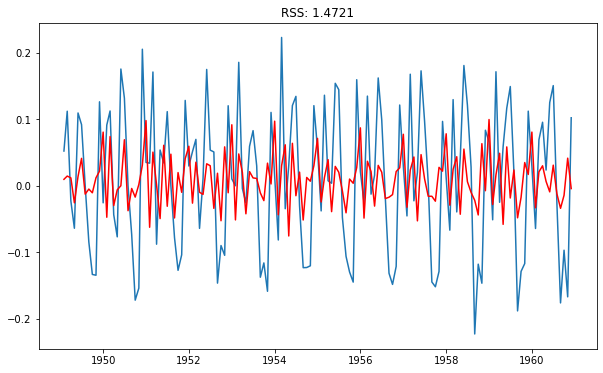

In [24]:
#MA model
model = ARIMA(indexedDataset_logScale, order = (0, 1, 2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - datasetLogDiffShifting["Passengers"])**2))
print('Plotting MA model')

C:\Users\Anarchy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Anarchy\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 1.0292')

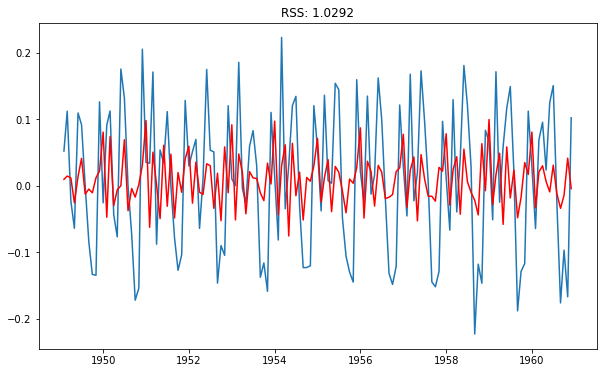

In [25]:
#ARIMA
model = ARIMA(indexedDataset_logScale, order = (2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - datasetLogDiffShifting["Passengers"])**2))


In [26]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy = True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017492
1949-04-01    0.027671
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [27]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027072
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026332
dtype: float64

In [28]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Passengers'].iloc[0], index=indexedDataset_logScale['Passengers'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()



Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1026')

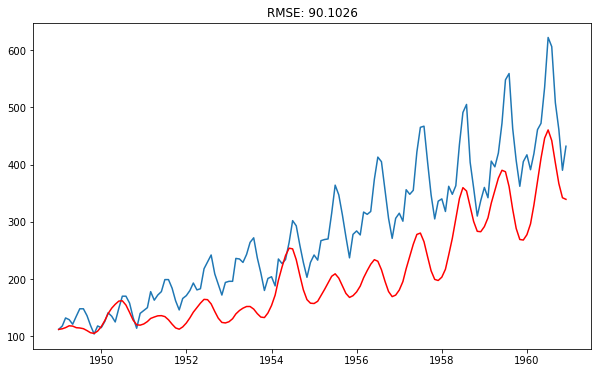

In [29]:
predictions_ARIMA= np.exp(predictions_ARIMA_log) 
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA, color='red')

plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-indexedDataset["Passengers"])**2)/len(indexedDataset["Passengers"])))


RMSE is an acronym for Root Mean Square Error, which is the square root of value obtained from Mean Square Error function.
Using RMSE, we can easily plot a difference between the estimated and actual values of a parameter of the model.
By this, we can clearly judge the efficiency of the model. Thus the model has a 90.1026% accuracy

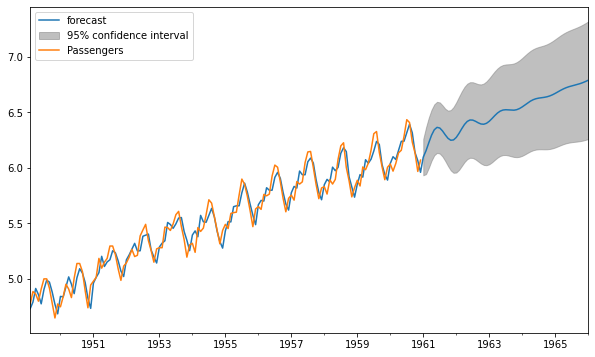

In [30]:
# Now let's forecast the next year
results_ARIMA.plot_predict(1,204) #currently there are 144 records, to predict the next 5 years it will be 144+(12*5) = 204
#the "1" in (1,204) enables the graph to give the 1st index of the TS then the next 203 data points
plt.legend(loc='upper left')

In [31]:
results_ARIMA.forecast(steps=120)
#results in an array format

(array([6.09553375, 6.15281383, 6.2244296 , 6.29241119, 6.34164758,
        6.36359419, 6.35784746, 6.33139353, 6.2959757 , 6.26447724,
        6.24738325, 6.25025173, 6.27275854, 6.30940357, 6.35151569,
        6.38988755, 6.41727494, 6.43011164, 6.42906784, 6.4184256 ,
        6.40456204, 6.3940365 , 6.39183116, 6.4001955 , 6.41833763,
        6.44295508, 6.46937562, 6.4929413 , 6.51024268, 6.51989175,
        6.52267703, 6.52112492, 6.51864615, 6.51853771, 6.52312009,
        6.53322462, 6.54812993, 6.56591704, 6.58410475, 6.60036717,
        6.61313444, 6.62192951, 6.62737946, 6.63093273, 6.63438825,
        6.63938119, 6.64696646, 6.65739996, 6.67015497, 6.6841444 ,
        6.69806828, 6.71078109, 6.7215794 , 6.73034187, 6.73750006,
        6.74386566, 6.75037507, 6.75782779, 6.76668875, 6.77700027,
        6.78841536, 6.80033082, 6.81207432, 6.82309001, 6.83307378,
        6.84202731, 6.85022547, 6.85811453, 6.86617572, 6.87479387,
        6.88416545, 6.89426634, 6.90488149, 6.91